In [1]:
import torch, pickle, time, os, random
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric as tg
from torch_geometric.loader import DataLoader
# accelerate huggingface to GPU
if torch.cuda.is_available():
    from accelerate import Accelerator
    accelerator = Accelerator()
    device = accelerator.device

torch.manual_seed(42)
random.seed(42)

In [2]:
os.listdir('../../../../scratch/gpfs/cj1223/GraphStorage/')

['vlarge_all_multit_z0.0_standard_stand',
 'medium_beforeafter',
 'medium_redshift_50_all',
 'vlarge_all_multit_z0.5_power_quant',
 'vlarge_all_multit_z0.0_None',
 'vlarge_all_multit_z2.0_standard_quant',
 'medium_smass_z1.0_standard',
 'test_onlyhmass_smass',
 'medium_redshift_80_all',
 'vlarge_all_final',
 'vlarge_all_multit_z1.0_standard_stand',
 'vlarge_all_multit_z1.0_power_quant',
 'medium_all_q_diffbeforeafter',
 'vlarge_redshift_85_all',
 'vlarge_all_multi_z0.5_quantile',
 'medium_all_smass',
 'medium_onlyhmass_smass',
 'vlarge_all_multi_z1.0_power',
 'vlarge_all_multit_z0.0_quantile_quant',
 'vlarge_all_multit_z0.0_standard_quant',
 'vlarge_all_multit_z0.5_quantile_quant',
 'medium_scaleonly_smass',
 'vlarge_all_multi_z0.5_None',
 'vlarge_all_multit_z2.0_None',
 'vlarge_all_multit_z1.0_standard_quant',
 'vlarge_all_multit_z0.0_power_quant',
 'vlarge_all_multi_z0.5_standard',
 'vlarge_redshift_50_all',
 'vlarge_all_multit_z0.5_standard_quant',
 'vlarge_all_multit_z1.0_power_sta

In [3]:
# case='medium_hmassonly_smass'
# case='medium_scaleonly_smass'
### this didn't work as well as I initially thought, must have done something wrong, but still better than base
# case='medium_onlyedge_smass' 
# case='medium_noinfo_smass' 
# case='vlarge_all_smass'
# case='vlarge_all_smass_standard'
# case='vlarge_all_smass_power'
# case='test_z1.5_standard'
# case='medium_smass_z1.0_standard'
# case='medium_smass_z0.0_quantile'
case='test_multi_z0.0_quantile'
case='vlarge_all_multit_z0.0_quantile_quant'
case='vlarge_all_smass_z0.0_quantile_quant'

data=pickle.load(open(f'../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'rb'))

In [4]:
# case='medium_all_smass'
# data1=pickle.load(open(f'../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'rb'))
# k=0
# data[k].x==data1[k].x

In [5]:
ls=[]
for d in data:
    ls.append(len(d.x.numpy()))

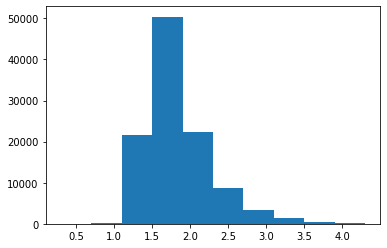

In [6]:
plt.hist(np.log10(ls));

In [7]:
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, LayerNorm
from torch_geometric.nn import SAGEConv, global_mean_pool, norm, global_max_pool, global_add_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, nlin=3):
        super(GCN, self).__init__()
        
        self.conv1 = SAGEConv(data[0].num_node_features, hidden_channels) ##use meta-layer
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        self.conv5 = SAGEConv(hidden_channels, hidden_channels)
        
        
        # Our final linear layer will define our output
        self.norm = LayerNorm(normalized_shape=hidden_channels) # layer_norm instead
        self.lin1 = Linear(hidden_channels, 1)
        
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = self.conv5(x, edge_index)
        x = x.relu()
        x = global_add_pool(x, batch)  ## Miles says use sumpool

        x = self.lin1(self.norm(x))
#         x=self.lin1(x)
        return x
    
model = GCN(hidden_channels=64)
next(model.parameters()).is_cuda ##check number one

False

In [8]:
criterion = torch.nn.MSELoss()
n_epochs=10
n_trials=1
batch_size=128
split=0.8
test_data=data[int(len(data)*split):]
train_data=data[:int(len(data)*split)]
l1_lambda = 0
l2_lambda = 0

In [9]:
trains, tests, scatter = [], [], []
yss, preds=[],[]
model = GCN(hidden_channels=64)
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=1, num_workers=4)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=0,num_workers=4)    
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
_, _, test_loader = accelerator.prepare(model, optimizer, test_loader)
model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)
print('GPU ', next(model.parameters()).is_cuda)
# Initialize our train function
def train():
    model.train()
    
    for data in train_loader:  
        out = model(data.x, data.edge_index, data.batch)  
        loss = criterion(out, data.y.view(-1,1)) 
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())


        loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm
#             loss.backward()
        accelerator.backward(loss)
        optimizer.step() 
        optimizer.zero_grad() 
    print(loss, l1_norm*l1_lambda, l2_norm*l2_lambda)
 # test function

def test(loader):
    model.eval()

    correct = 0
    with torch.no_grad(): ##this solves it!!!
        for dat in loader: 
            out = model(dat.x, dat.edge_index, dat.batch) 
    #         print(out)
            correct += torch.std(out - dat.y.view(-1,1))
    return correct/len(loader.dataset)

/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


GPU  True


In [10]:
def test(loader, model):
    '''returns targets and predictions'''
    ys, pred,xs, Mh=[],[],[], []
    model.eval()
    with torch.no_grad():
        for dat in loader: 
            out = model(dat.x, dat.edge_index, dat.batch) 
            pred.append(out.view(1,-1).cpu().detach().numpy())
            ys.append(np.array(dat.y.cpu().numpy())) 
            u, counts = np.unique(dat.batch.cpu().numpy(), return_counts=1)
            xs.append(np.array(torch.tensor_split(dat.x.cpu(), torch.cumsum(torch.tensor(counts[:-1]),0)), dtype=object))
            ## compile lists
    ys=np.hstack(ys)
    pred=np.hstack(pred)[0]
    xs=np.hstack(xs)
    xn=[]
    for x in xs:
        x0=x.cpu().detach().numpy()
        xn.append(x0)
        Mh.append(x0[0][3])
    return ys,pred,xn, Mh

In [11]:
#this uses about 1 GB of memory on the GPU

start=time.time()
# for epoch in range(n_epochs):
for epoch in range(10):

    train()

#     if (epoch+1)%2==0:
#         train_acc = test(train_loader)
#         test_acc = test(test_loader)
#         tr_acc.append(train_acc)
#         te_acc.append(test_acc)
#         print(f'Epoch: {epoch+1:03d}, Train scatter: {np.sqrt(train_acc):.4f}, Test scatter: {np.sqrt(test_acc):.4f}')
stop=time.time()
spent=stop-start
print(f"{spent:.2f} seconds spent training, {spent/n_epochs:.3f} seconds per epoch. Processed {len(data)*split*n_epochs/spent:.0f} trees per second")
# ys, pred=[],[]
# def test(loader):
#     model.eval()

#     correct = 0
#     for dat in loader: 
#         out = model(dat.x, dat.edge_index, dat.batch) 
#         pred.append(out.view(1,-1).cpu().detach().numpy())
#         ys.append(np.array(dat.y.cpu())) 
# ys=np.hstack(ys)
# pred=np.hstack(pred)[0]
# scatter.append(np.std(ys-pred))
# yss.append(ys)
# preds.append(pred)

tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0140, device='cuda:0', grad_fn=<AddBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0182, device='cuda:0', grad_fn=<AddBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<AddBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1971, device='cuda:0', grad_fn=<AddBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>) tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0091, device='cuda:0', grad_fn=

In [12]:
train_acc = test(train_loader, model)
test_acc = test(test_loader, model)

/tmp/ipykernel_26539/55354286.py:11: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  xs.append(np.array(torch.tensor_split(dat.x.cpu(), torch.cumsum(torch.tensor(counts[:-1]),0)), dtype=object))


In [13]:
ytr, ptr,xtr, Mhtr = train_acc

In [14]:
yte, pte, xte, Mhte = test_acc

0.15385556

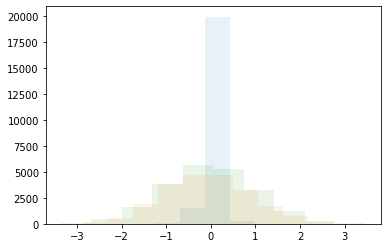

In [19]:
plt.hist(yte-pte, alpha=0.1) 
plt.hist(pte, alpha=0.1)
plt.hist(yte, alpha=0.1)
np.std(yte-pte)

/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: operands could not be broadcast together with shapes (4928,) (616,) 

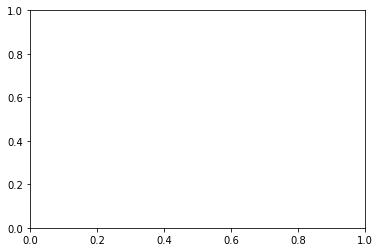

In [127]:
import matplotlib as mpl
hist=plt.hist2d(Mhtr,ptr-ytr, bins=100, norm=mpl.colors.LogNorm(), cmap=plt.cm.cividis);
plt.colorbar()

Text(0.5, 1.0, '0.11128123')

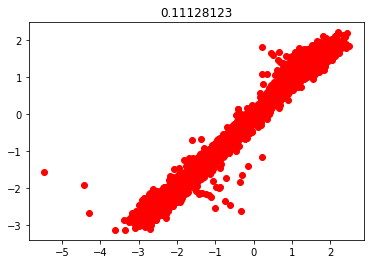

In [86]:
plt.plot(yte, pte, 'ro')
plt.title(np.std(yte-pte))

In [48]:
tr_acc, te_acc=[],[]
tests.append(te_acc)
trains.append(tr_acc)

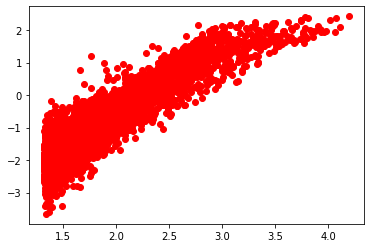

In [49]:
plt.plot(Mhtr,ytr,'ro')

In [12]:
test(train_loader) #this crashes everything, estimate is that it uses \approx 30 GB and I have no idea

tensor(0.0036, device='cuda:0')

In [ ]:
np.mean(scatter), np.std(scatter)

In [ ]:
np.min(tests)

In [ ]:
plt.plot(tr_acc, label='train loss')
plt.plot(te_acc, label='test loss')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [ ]:
ys, pred=[],[]  
def test(loader):
    model.eval()
 
    correct = 0
    for dat in loader: 
        out = model(dat.x, dat.edge_index, dat.batch) 
        pred.append(out.view(1,-1).cpu().detach().numpy())
        ys.append(np.array(dat.y.cpu())) 
test(test_loader)
# test(train_loader)
ys=np.hstack(ys)
pred=np.hstack(pred)[0]

In [ ]:
fig, ax= plt.subplots(2, figsize=(9,12))
bins=50
ax[0].hist(ys, bins=bins, range=(np.percentile(np.hstack([ys,pred]), [1,99])), label='true',  histtype='step')
ax[0].hist(pred, bins=bins, range=(np.percentile(np.hstack([ys,pred]), [1,99])), label='pred', histtype='step')
ax[1].hist((ys-pred), bins=bins,range=(np.percentile(ys-pred, [1,99])),  histtype='step', label='residuals');
ax[0].legend()
ax[1].legend()
ax[0].set(title='Predicted/true stellar mass', xlabel='log10(M_stellar)', ylabel='N')
ax[1].set(title=f'Residuals, scatter is {np.std(ys-pred):.3f}',xlabel='log10(M_stellar)_true-log10(M_stellar)_predicted', ylabel='N')

In [ ]:
fig, ax =plt.subplots(figsize=(12,9))
ax.plot(ys,pred, 'ro')
ax.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
ax.set(xlabel='true',ylabel='predicted', title='True/predicted corr')
ax.legend()

In [ ]:
fig, ax =plt.subplots(figsize=(12,9))
h = ax.hist2d(ys,pred, bins=50, range=[np.percentile(ys, [1,99]),np.percentile(pred, [1,99])])
fig.colorbar(h[3], ax=ax)
ax.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
ax.set(xlabel='true',ylabel='predicted', title='True/predicted corr')
ax.legend()

In [ ]:
Mh=[]
for x in xes:
    Mh.append(x[0,3])
plt.plot(Mh, pred, 'o', markersize=1) 

In [ ]:
x,y=[], []
for d in data:
    x.append(d.x[0,3].numpy())
    y.append(d.y.numpy())    

In [ ]:
plt.plot(x, y, 'o', markersize=1) 

In [ ]:
## remember to validate that test/val/train are actually comparable
## create toy problem (predict variance of all halo masses eg, verifying that in takes into account edges)
## same, predict average of the difference of post-merge halo and pre merger halos

## try different pools

In [ ]:
xte, yte, lte = [], [], []
for d in test_data:
    xte.append(d.x.numpy()[0,3])
    yte.append(d.y.numpy())    
    lte.append(np.log10(len(d.x.numpy()))   ) 
yte=np.vstack(yte)

In [ ]:
xtr, ytr, ltr = [], [], []
for d in train_data:
    xtr.append(d.x.numpy()[0,3])
    ytr.append(d.y.numpy())    
    ltr.append(np.log10(len(d.x.numpy()))   ) 
ytr=np.vstack(ytr)

In [ ]:
bins=20
fig, ax = plt.subplots(3, figsize=(12,12))
ax[0].hist(xtr, bins=bins, histtype='step', density=1, label='train')
ax[0].hist(xte, bins=bins, histtype='step', density=1, label='test')
ax[0].set(xlabel='Final halo mass')

ax[1].hist(ytr, bins=bins, histtype='step', density=1, label='train')
ax[1].hist(yte, bins=bins, histtype='step', density=1, label='test')
ax[1].set(xlabel='Stellar mass')

ax[2].hist(ltr, bins=bins, histtype='step', density=1, label='train')
ax[2].hist(lte, bins=bins, histtype='step', density=1, label='test');
ax[2].set(xlabel='log10(Tree length)')

for a in ax:
    a.set(yscale='log')
    a.legend()

In [51]:
import multiprocessing
multiprocessing.cpu_count()

28

In [52]:
os.cpu_count()

28